# Zebrafish pigmentation

This tutorial uses data from [Saunders, et al (2019)](https://elifesciences.org/articles/45181). Special thanks also go to [Lauren](https://twitter.com/LSaund11) for the tutorial improvement. 

In this [study](https://elifesciences.org/articles/45181), the authors profiled thousands of neural crest-derived cells from trunks of post-embryonic zebrafish. These cell classes include pigment cells, multipotent pigment cell progenitors, peripheral neurons, Schwann cells, chromaffin cells and others. These cells were collected during an active period of post-embryonic development, which has many similarities to fetal and neonatal development in mammals, when many of these cell types are migrating and differentiating as the animal transitions into its adult form. This study also explores the role of thyroid hormone (TH), a common endocrine factor, on the development of these different cell types. 

Such developmental and other dynamical processes are especially suitable for dynamo analysis as dynamo is designed to accurately estimate direction and magnitude of expression dynamics (`RNA velocity`), predict the entire lineage trajectory of any intial cell state (`vector field`), characterize the structure (`vector field topology`) of full gene expression space, as well as fate commitment potential (`single cell potential`). 

Import the package and silence some warning information (mostly `is_categorical_dtype` warning from anndata)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import dynamo as dyn 
from dynamo.configuration import DKM
import numpy as np

this is like R's sessionInfo() which helps you to debug version related bugs if any. 

## Load data

In [2]:
adata = dyn.sample_data.scEU_seq_rpe1()
adata_origin = dyn.sample_data.scEU_seq_rpe1()

|-----> Downloading scEU_seq data
|-----> Downloading data to ./data/rpe1.h5ad
|-----> Downloading scEU_seq data
|-----> Downloading data to ./data/rpe1.h5ad


In [3]:
rpe1_kinetics = adata[adata.obs.exp_type=='Pulse', :]
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(str)
rpe1_kinetics.obs.loc[rpe1_kinetics.obs['time'] == 'dmso', 'time'] = -1
rpe1_kinetics.obs['time'] = rpe1_kinetics.obs['time'].astype(float)
rpe1_kinetics = rpe1_kinetics[rpe1_kinetics.obs.time != -1, :]

rpe1_kinetics.layers['new'], rpe1_kinetics.layers['total'] = rpe1_kinetics.layers['ul'] + rpe1_kinetics.layers['sl'], rpe1_kinetics.layers['su'] + rpe1_kinetics.layers['sl'] + rpe1_kinetics.layers['uu'] + rpe1_kinetics.layers['ul']

del rpe1_kinetics.layers['uu'], rpe1_kinetics.layers['ul'], rpe1_kinetics.layers['su'], rpe1_kinetics.layers['sl']
adata = rpe1_kinetics

## Apply pearson residual normalization on different layers according `select_genes_key`. We may use other select_genes function combined with pearson residual normalization.

In [4]:
# adata = dyn.sample_data.zebrafish()
from dynamo.preprocessing import Preprocessor
import pearson_residual_normalization_recipe
def normalize_new_total_pearson_residuals(adata):
    return pearson_residual_normalization_recipe.normalize_layers_pearson_residuals(adata, layers=["new", "total"])
preprocessor = Preprocessor(\
                            # filter_cells_by_outliers_function=None,
                            # filter_genes_by_outliers_function=None,
                            # normalize_by_cells_function=None,
                            select_genes_function=pearson_residual_normalization_recipe.select_genes_by_pearson_residual,
                            normalize_selected_genes_function=normalize_new_total_pearson_residuals,
                            use_log1p=False)
                           
preprocessor.preprocess_adata(adata, tkey='time')


|-----> Running preprocessing pipeline...
|-----------> <insert> {} to uns['pp'] in AnnData Object.
|-----> data contains labeling info, checking tkey:time
|-----> 
Dynamo detects your labeling data is from a kin experiment. If experiment type is not corrent, please correct 
this via supplying the correct experiment_type (one of `one-shot`, `kin`, `deg`) as needed.
|-----------> <insert> tkey=time to uns['pp'] in AnnData Object.
|-----------> <insert> experiment_type=None to uns['pp'] in AnnData Object.
|-----> making adata observation index unique...
|-----> applying collapse species adata...
|-----> applying convert_gene_name function...
|-----> convert ensemble name to official gene name
|-----? Your adata object uses non-official gene names as gene index. 
Dynamo is converting those names to official gene names.
|-----> Storing myGene name info into local cache db: mygene_cache.sqlite.


Error: The requests_cache python module is required to use request caching.
See - https://requests-cache.readthedocs.io/en/latest/user_guide.html#installation
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-11848...done.


|-----> Subsetting adata object and removing Nan columns from adata when converting gene names.


Finished.
1 input query terms found dup hits:
	[('ENSG00000229425', 2)]
33 input query terms found no hit:
	['ENSG00000116957', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205664', 'ENS
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


|-----> filtering outlier cells...
|-----------> filtering cells by layer:X
|-----> skip filtering by layer:spliced as it is not in adata.
|-----> skip filtering by layer:unspliced as it is not in adata.
|-----> skip filtering by layer:protein as it is not in adata.
|-----> <insert> pass_basic_filter to obs in AnnData Object.
|-----------> inplace subsetting adata by filtered genes
|-----> filtering outlier genes...
|-----> applying normalizing by cells function...
|-----> selecting genes...
|-----> Gene selection and normalization on layer: X
|-----> extracting highly variable genes
|-----> normalizing selected genes...
|-----> applying Pearson residuals to new
|-----> replacing layer <new> with pearson residual normalized data.
|-----> [pearson residual normalization] in progress: 100.0000%
|-----> [pearson residual normalization] finished [1.1729s]
|-----> applying Pearson residuals to total
|-----> replacing layer <total> with pearson residual normalized data.
|-----> [pearson resi

In [5]:
dyn.tl.reduceDimension(adata,basis="pca")


|-----> retrive data for non-linear dimension reduction...
|-----> perform umap...
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [21.8834s]


In [6]:
dyn.tl.dynamics(adata, model='stochastic', cores=3) 

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----? Looks like you are using minutes as the time unit. For the purpose of numeric stability, we recommend using hour as the time unit.
|-----> calculating first/second moments...
|-----> [moments calculation] in progress: 100.0000%
|-----> [moments calculation] finished [15.6481s]
|-----? Your adata only has labeling data, but `NTR_vel` is set to be `False`. Dynamo will reset it to `True` to enable this analysis.
|-----> experiment type: kin, method: direct, model: stochastic
estimating kinetic-parameters using kinetic model:   0%|          | 0/1000 [00:00<?, ?it/s]|-----? Some standard deviations are 0; Set to 1 instead.
|-----? Some standard deviations are 0; Set to 1 instead.
estimating kinetic-parameters using kinetic model:   0%|          | 4/1000 [00:00<00:34, 29.06it/s]|-----? Some standard deviations are 0; Set to 1 instead.
estimating kinetic-paramet

AnnData object with n_obs × n_vars = 2793 × 11385
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'pass_basic_filter', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_valid_ind', 'neighbors', 'umap_fit', 'dynamics'
    obsm: 'X_pca', 'X_umap', 'X'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'velocity_N', 'velocity_T'
    obsp: 'moments_con'

In [7]:
adata

AnnData object with n_obs × n_vars = 2793 × 11385
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'pass_basic_filter', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'use_for_dynamics'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_valid_ind', 'neighbors', 'umap_fit', 'dynamics'
    obsm: 'X_pca', 'X_umap', 'X'
    layers: 'new', 'total', 'X_total', 'X_new', 'M_t', 'M_tt', 'M_n', 'M_tn', 'M_nn', 'velocity_N', 'velocity_T'
    obsp: 'moments_con'

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0011s]
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> <insert> connectivities to obsp in AnnData Object.
|-----> <insert> distances to obsp in AnnData Object.
|-----> <insert> neighbors to uns in AnnData Object.
|-----> <insert> neighbors.indices to uns in AnnData Object.
|-----> <

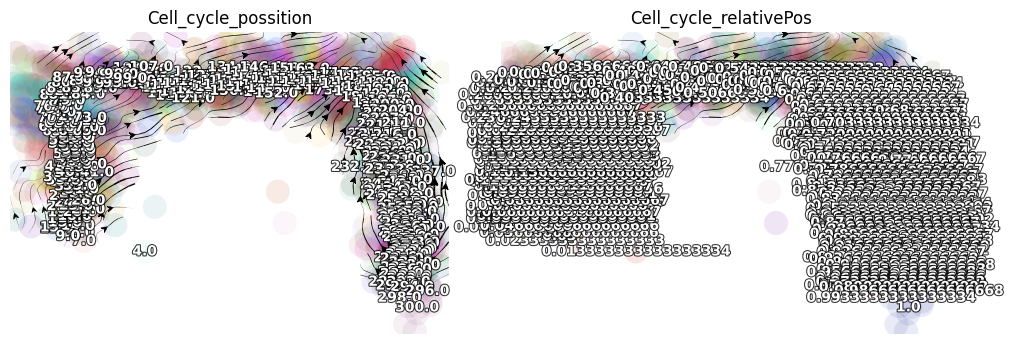

AnnData object with n_obs × n_vars = 2793 × 11385
    obs: 'Plate_Id', 'Condition_Id', 'Well_Id', 'RFP_log10_corrected', 'GFP_log10_corrected', 'Cell_cycle_possition', 'Cell_cycle_relativePos', 'exp_type', 'time', 'pass_basic_filter', 'total_Size_Factor', 'initial_total_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'Size_Factor', 'initial_cell_size'
    var: 'Gene_Id', 'query', 'scopes', '_id', '_score', 'symbol', 'notfound', 'pass_basic_filter', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'gene_highly_variable', 'use_for_pca', 'alpha', 'a', 'b', 'alpha_a', 'alpha_i', 'beta', 'p_half_life', 'gamma', 'half_life', 'cost', 'logLL', 'use_for_dynamics', 'gamma_r2', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_valid_ind', 'neighbors', 'umap_fit', 'dynamics', 'grid_velocity_RFP_GFP', 'Cell_cycle_possition_colors', 'Cell_cycle_relativePos_colors'
    obsm: 'X_pca', 'X_umap', 'X', 'X_RFP_GFP', 'velocity_RFP_GFP'
    l

In [8]:
def streamline(adata):
    dyn.tl.reduceDimension(adata, reduction_method='umap')
    dyn.tl.cell_velocities(adata, enforce=True, vkey='velocity_T', ekey='M_t', basis='RFP_GFP')
    dyn.pl.streamline_plot(adata, color=['Cell_cycle_possition', 'Cell_cycle_relativePos'], basis='RFP_GFP')

    return adata
adata.obsm['X_RFP_GFP'] = adata'.obs.loc[:, ['RFP_log10_corrected', 'GFP_log10_corrected']].values.astype('float')
streamline(adata)

In [9]:
dyn.pl.umap(adata, color="Cell_type", figsize=(12, 12))

KeyError: 'Could not find key Cell_type in .var_names or .obs.columns.'

<Figure size 1200x1200 with 0 Axes>

In [ ]:
adata.var_names[adata.var[DKM.VAR_GENE_HIGHLY_VARIABLE_KEY]]
print((adata.var["highly_variable_rank"].isna()).sum())
print("#highly variable genes", (~adata.var["highly_variable_rank"].isna()).sum())

highly_variable_genes = adata.var_names[~adata.var["highly_variable_rank"].isna()]
adata.var["highly_variable_rank"][highly_variable_genes].sort_values(ascending=False);

In [ ]:
dyn.pl.streamline_plot(adata, color=['Cell_type'], basis='umap', show_legend='on data', show_arrowed_spines=True);


In [ ]:
dyn.pl.umap(adata, color=['tfec', 'pnp4a'])

In [ ]:
dyn.pl.phase_portraits(adata, genes=['tfec', 'pnp4a'],  figsize=(6, 4), color='Cell_type')

In [ ]:
adata.layers["spliced"]

In [ ]:
print(adata.X.min(), adata.X.max(), adata.X.mean(),  temp.std())
temp = adata.layers["spliced"][~np.isnan(adata.layers["spliced"])]
print(temp.min(), temp.max(), temp.mean(),  temp.std())
temp = adata.layers["unspliced"][~np.isnan(adata.layers["unspliced"])]
print(temp.min(), temp.max(), temp.mean(), temp.std())

In [ ]:
adata.uns["pp"]